In [1]:
# this notebook will demo basic feature of langgraph by building a simple chatbot
# it will first create llm instance which is connected to a locally host LLM
import multiprocessing

from langchain_community.chat_models import ChatLlamaCpp

local_model = "./models/Phi-3-medium-4k-instruct-Q4_K_M.gguf"

llm = ChatLlamaCpp(
    temperature=0.5,
    model_path=local_model,
    n_ctx=10000,
    n_gpu_layers=100000,
    n_batch=3000,  # Should be between 1 and n_ctx, consider the amount of VRAM in your GPU.
    max_tokens=2048,
    n_threads=multiprocessing.cpu_count() - 1,
    repeat_penalty=1.5,
    top_p=0.5,
    verbose=True,
)

llama_model_loader: loaded meta data with 30 key-value pairs and 243 tensors from ./models/Phi-3-medium-4k-instruct-Q4_K_M.gguf (version GGUF V3 (latest))
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = phi3
llama_model_loader: - kv   1:                               general.name str              = Phi3
llama_model_loader: - kv   2:                        phi3.context_length u32              = 4096
llama_model_loader: - kv   3:  phi3.rope.scaling.original_context_length u32              = 4096
llama_model_loader: - kv   4:                      phi3.embedding_length u32              = 5120
llama_model_loader: - kv   5:                   phi3.feed_forward_length u32              = 17920
llama_model_loader: - kv   6:                           phi3.block_count u32              = 40
llama_model_loader: - kv   7:                  phi3.attention.head_co

In [4]:
import os
from helper import get_api_key
from langchain_community.tools.tavily_search import TavilySearchResults

# set the TAVILY_API_KEY environment variable to the API key
os.environ["TAVILY_API_KEY"] = get_api_key(1)

In [2]:
# Add memory using sqlite checkpoint
from langgraph.checkpoint.sqlite import SqliteSaver

memory = SqliteSaver.from_conn_string(":memory:")

In [5]:
# build out the graph with simple tools node and chatbot node

from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


tool = TavilySearchResults(max_results=2)
tools = [tool]
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")


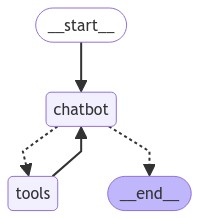

In [6]:
from helper import render_graph
# then compile the graph with memory checkpoint
graph = graph_builder.compile(checkpointer=memory)
render_graph(graph)

In [7]:
# set config to thread_id 1
config = {"configurable": {"thread_id": "1"}}

# now call the chatbot with user input
user_input = "Hi there! My name is Victor."

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi there! My name is Victor.



llama_print_timings:        load time =     134.15 ms
llama_print_timings:      sample time =      16.23 ms /    64 runs   (    0.25 ms per token,  3943.31 tokens per second)
llama_print_timings: prompt eval time =     134.09 ms /    11 tokens (   12.19 ms per token,    82.04 tokens per second)
llama_print_timings:        eval time =    1366.01 ms /    63 runs   (   21.68 ms per token,    46.12 tokens per second)
llama_print_timings:       total time =    1539.25 ms /    74 tokens


================================== Ai Message ==================================

 Hello, Victror – it's a pleasure to meet you virtually today; I hope your day has been going well so far? How can we make the most of our time together right now in this digital space that connect us across vast distances and differences yet unites through shared interests or curiosities.


In [8]:
# check if the chatbot can recall information
user_input = "Remember my name?"

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember my name?


Llama.generate: prefix-match hit

llama_print_timings:        load time =     134.15 ms
llama_print_timings:      sample time =      18.71 ms /    83 runs   (    0.23 ms per token,  4436.60 tokens per second)
llama_print_timings: prompt eval time =      71.79 ms /     8 tokens (    8.97 ms per token,   111.44 tokens per second)
llama_print_timings:        eval time =    1740.83 ms /    82 runs   (   21.23 ms per token,    47.10 tokens per second)
llama_print_timings:       total time =    1863.74 ms /    90 tokens


================================== Ai Message ==================================

 Certainly, Victor! Your introduction was quite clear: "My Name is Victror." I'm here to assist you with any questions about the topic of comparison—specifically between friendly versus hostile interactions in various contexts such as personal relationships and international diplomacy. If there are specific aspects or examples within this theme that interest, please feel free share them for a more tailored discussion!


In [9]:
# we can inspect the state of the graph
snapshot = graph.get_state(config)
snapshot

StateSnapshot(values={'messages': [HumanMessage(content='Hi there! My name is Victor.', id='7792c2cf-6e45-4d4b-9c5c-2e17b6e88ac7'), AIMessage(content=" Hello, Victror – it's a pleasure to meet you virtually today; I hope your day has been going well so far? How can we make the most of our time together right now in this digital space that connect us across vast distances and differences yet unites through shared interests or curiosities.", response_metadata={'finish_reason': 'stop'}, id='run-7ed8da96-f852-4069-971a-1ddd0d298224-0'), HumanMessage(content='Remember my name?', id='ebbfef87-0ee3-410c-9a8f-3bc542524699'), AIMessage(content=' Certainly, Victor! Your introduction was quite clear: "My Name is Victror." I\'m here to assist you with any questions about the topic of comparison—specifically between friendly versus hostile interactions in various contexts such as personal relationships and international diplomacy. If there are specific aspects or examples within this theme that int